In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector

In [2]:
vector.register_awkward() 

In [3]:
DATATYPE="data"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="." # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

In [4]:
!curl 'https://cernbox.cern.ch/remote.php/dav/public-files/JIjQaAYEQnmRDkX/291694/AnalysisResults.root' > run291694.data.root

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  100M  100  100M    0     0  3941k      0  0:00:26  0:00:26 --:--:-- 4228k


In [5]:
!file *.root
file = uproot.open("run291694.data.root")
file.keys()
events = file["eventsTree"]
events.show()

run290223.data.root: ROOT file Version 62406 (Compression: 1)
run291694.data.root: ROOT file Version 61600 (Compression: 1)
run291694.mc.root:   ROOT file Version 61600 (Compression: 1)
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
xVtx                 | double                   | AsDtype('>f8')
yVtx                 | double                   | AsDtype('>f8')
zVtx                 | double                   | AsDtype('>f8')
isCINT               | bool                     | AsDtype('bool')
isCMSL               | bool                     | AsDtype('bool')
isCMSH               | bool                     | AsDtype('bool')
isCMLL               | bool                     | AsDtype('bool')
isCMUL               | bool                     | AsDtype('bool')
nMuons               | int32_t                  | AsDtype('>i4

[{nMuons: 0, isCINT: True, isCMUL: False, ... Muon_matchedTrgThreshold: []}] 
 [{nMuonsGen: 2, Muon_GenE: [6.58, 11.3, ... Muon_GenMotherPDGCode: [100443, 100443]}] 

a
[{nMuons: 1, isCINT: True, isCMUL: False, ... Muon_matchedTrgThreshold: [2]}] 
 [{nMuonsGen: 2, Muon_GenE: [53.2, 42.9], ... Muon_GenMotherPDGCode: [443, 443]}] 

a
[{nMuons: 2, isCINT: True, isCMUL: False, isCMSL: True, ... 2, 2]}] 
 [{nMuonsGen: 2, Muon_GenE: [26.4, 16.4], ... Muon_GenMotherPDGCode: [443, 443]}] 

a
[{nMuons: 1, isCINT: True, isCMUL: False, ... Muon_matchedTrgThreshold: [2]}] 
 [{nMuonsGen: 2, Muon_GenE: [22.6, 7.83], ... Muon_GenMotherPDGCode: [443, 443]}] 

a
[{nMuons: 1, isCINT: True, isCMUL: True, ... Muon_matchedTrgThreshold: []}] 
 [{nMuonsGen: 2, Muon_GenE: [8.05, 85.3], ... Muon_GenMotherPDGCode: [443, 443]}] 

a
[{nMuons: 1, isCINT: True, isCMUL: False, isCMSL: True, ... 2, 2]}] 
 [{nMuonsGen: 2, Muon_GenE: [27.7, 14.1, ... Muon_GenMotherPDGCode: [100443, 100443]}] 

a
[{nMuons: 0, isCINT: Tr

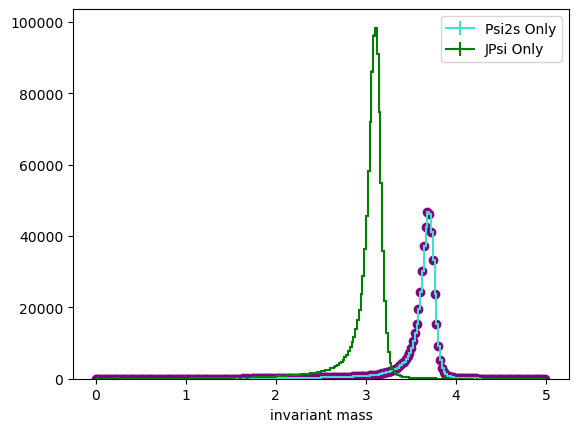

In [6]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
from scipy.optimize import curve_fit

vector.register_awkward() 

DATATYPE="mc"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="../data_mc" # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

#!curl 'https://cernbox.cern.ch/remote.php/dav/public-files/nbPmKbcsJvZrjjx/291694/AnalysisResults.root' > run291694.mc.root
#!file *.root
#file = uproot.open("run291694.mc.root")
#file.keys()

#def data_url(run,is_mc):
#    basesrc="https://cernbox.cern.ch/remote.php/dav/public-files/VJZ5whMyF5Kxldd/dimuonData_LHC18m"
#    if is_mc==True:
#        basesrc+="MC"
#    return f"{basesrc}/{run}/AnalysisResults.root"

#def data_file_path(run,is_mc=IS_MC,dest=BASEDIR):
#    datatype="mc" if is_mc else "data"
#    print({dest},"/run",{run},".",{datatype},".root")
#    return f"{dest}/run{run}.{datatype}.root"

#def copy_cmd(run,is_mc,dest):
#    return f"curl '{data_url(run,is_mc)}' > {data_file_path(run,is_mc,dest)}"

def CrystalBall2(x, mu, sigma, alpha, alphabis, n, nbis, N):
    A = ((n/np.abs(alpha))**n)*np.exp(-(np.abs(alpha)**2)/2.)
    B = (n/np.abs(alpha))-np.abs(alpha)
    C = ((nbis/np.abs(alphabis))**n)*np.exp(-(np.abs(alphabis)**2)/2.)
    D = (nbis/np.abs(alphabis))-np.abs(alphabis)
    y = np.array([], dtype=float)
    for i in x:
        if(((i-mu)/sigma > alpha) and ((i-mu)/sigma < alphabis)):
            y = np.append(y, np.exp(-((i-mu)**2)/(2*sigma**2)))
        elif ((i-mu)/sigma < alpha):
            y = np.append(y, A*((B- (i -mu)/(sigma))**(-n)))
        elif((i-mu)/sigma > alphabis):
            y = np.append(y, C*((D+ (i -mu)/(sigma))**(-nbis)))
        else:
            y = np.append(y, 0.)
    return y*N

#Gaussienne
def gauss(x,m,sigma,N):
    return N/(np.sqrt(2*math.pi)*sigma)*np.exp(-(x-m)**2/(2*sigma**2))

def getTracks_Psi(events, gen):
    i = gen["Muon_GenMotherPDGCode"] == 100443
    j = i[:,0]
    tracks = events[j]
    return ak.zip({
        "px":tracks["Muon_Px"],
                    "py":tracks["Muon_Py"],
                    "pz":tracks["Muon_Pz"],
                    "E":tracks["Muon_E"],
                    "charge":tracks["Muon_Charge"],
                    "thetaAbs":tracks["Muon_thetaAbs"],
                    "matched":tracks["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

def getTracks_Jpsi(events, gen):
    i = gen["Muon_GenMotherPDGCode"] == 443
    j = i[:,0]
    tracks = events[j]
    return ak.zip({
        "px":tracks["Muon_Px"],
                    "py":tracks["Muon_Py"],
                    "pz":tracks["Muon_Pz"],
                    "E":tracks["Muon_E"],
                    "charge":tracks["Muon_Charge"],
                    "thetaAbs":tracks["Muon_thetaAbs"],
                    "matched":tracks["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

def scan(dataDescription1, dataDescription2, 
              hInvMass_Psi:hist.Hist, hInvMass_Jpsi:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x),
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """
    
    for batch1, batch2 in zip(uproot.iterate(dataDescription1,
                                ["nMuons", "isCINT","isCMUL","isCMSL","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 step_size="100 MB", report=True), 
                             uproot.iterate(dataDescription2,
                                ["nMuonsGen", "Muon_GenE", "Muon_GenPx", "Muon_GenPy", "Muon_GenPz", "Muon_GenLabel","Muon_GenMotherPDGCode"],                                
                                 step_size="100 MB", report=True)):
        events=batch1[0] # batch[1] is the report info
        gen=batch2[0]
        print(events, "\n", gen, "\n")
        if len(events) < 1000:
            print("something is wrong",batch1[1], batch2[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] 
        
        tracks_Psi = getTracks_Psi(events, gen)
        tracks_Jpsi = getTracks_Jpsi(events, gen)
        
        pairs_Psi = ak.combinations(tracks_Psi, 2)
        one_Psi, two_Psi = ak.unzip(pairs_Psi)
        
        pairs_Jpsi = ak.combinations(tracks_Jpsi, 2)
        one_Jpsi, two_Jpsi = ak.unzip(pairs_Jpsi)
        
        #opposite_charge_cut = one.charge + two.charge == 0
        
        #quality_one = one[opposite_charge_cut]
        #quality_two = two[opposite_charge_cut]
        invariant_mass_Psi = (one_Psi + two_Psi).mass
        invariant_mass_Jpsi = (one_Jpsi + two_Jpsi).mass

        hInvMass_Psi.fill(ak.flatten(invariant_mass_Psi))
        hInvMass_Jpsi.fill(ak.flatten(invariant_mass_Jpsi))

        print("a")

        if verbose:
            print(batch1[1], "\n", batch2[1])


vhInvMass_Psi = hist.Hist(hist.axis.Regular(bins=250,start=0,stop=5,name='invariant mass'))
vhInvMass_Jpsi = hist.Hist(hist.axis.Regular(bins=250,start=0,stop=5,name='invariant mass'))            
    
scan(dataDescription1=f"{BASEDIR}/run*.{DATATYPE}.root:eventsTree",
     dataDescription2=f"{BASEDIR}/run*.{DATATYPE}.root:genTree",
     hInvMass_Psi=vhInvMass_Psi, hInvMass_Jpsi = vhInvMass_Jpsi,
          eventSelector=lambda x: x["isCMUL"]==True,
          trackSelector=lambda x: (x.eta>0))

x_data=[]
y_data_Psi=[]
y_data_Jpsi = []

#print(vhInvMass)
#print(vhInvMass[22])
      
for i in range(0,5000,20):
    x_data.append(i/1000)
#print(x_data)


for i in vhInvMass_Psi:
      y_data_Psi.append(i)
#print(y_data)

for i in vhInvMass_Jpsi:
      y_data_Jpsi.append(i)
#print(y_data)

#plt.plot(x_data,y_data,'g')
vhInvMass_Psi.plot(color="turquoise", label="Psi2s Only")
vhInvMass_Jpsi.plot(color="green", label = "JPsi Only")
plt.scatter(x_data,y_data_Psi, color="purple")
plt.legend()
plt.show()

[3.67603221e+00 7.76568675e-02 8.64937437e+03]


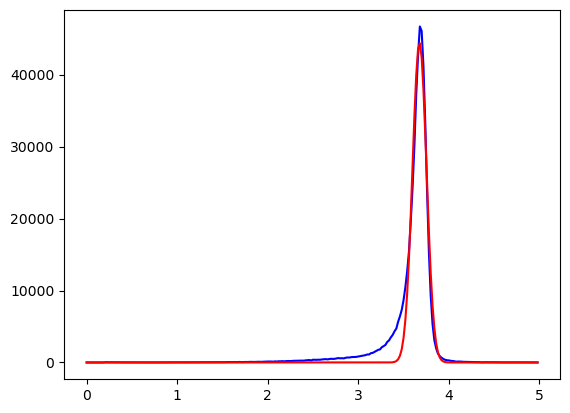

In [7]:
#fit avec gaussienne sur Psi
popt_gauss_Psi, pcov_gauss_Psi = curve_fit(gauss, x_data, y_data_Psi, p0=[3.5,0.1,1])
print(popt_gauss_Psi)
mu_fit_gauss_Psi=popt_gauss_Psi[0]
sigma_fit_gauss_Psi=popt_gauss_Psi[1]
N_fit_gauss_Psi=popt_gauss_Psi[2]
y_data_fit_gauss_Psi=gauss(x_data,mu_fit_gauss_Psi,sigma_fit_gauss_Psi,N_fit_gauss_Psi)
plt.plot(x_data,y_data_Psi,'b')
plt.plot(x_data,y_data_fit_gauss_Psi,'r')
plt.show()

/tmp/ipykernel_22583/1288034614.py:39: RuntimeWarning: invalid value encountered in double_scalars
  A = ((n/np.abs(alpha))**n)*np.exp(-(np.abs(alpha)**2)/2.)
/tmp/ipykernel_22583/1288034614.py:41: RuntimeWarning: invalid value encountered in double_scalars
  C = ((nbis/np.abs(alphabis))**n)*np.exp(-(np.abs(alphabis)**2)/2.)
/tmp/ipykernel_22583/1288034614.py:48: RuntimeWarning: invalid value encountered in double_scalars
  y = np.append(y, A*((B- (i -mu)/(sigma))**(-n)))


[ 3.68436492e+00  6.49423199e-02 -8.12727727e-01  2.14086825e+00
  2.96128883e+00  2.39892620e+00  4.71340464e+04]
Psi : mu =  3.6843649201165847 
 sigma =  0.06494231987817563 
 alpha =  -0.8127277269512803 
 alphabis =  2.140868246051813 
 n =  2.9612888277488696 
 nbis =  2.398926196259195 
 N =  47134.04635462629


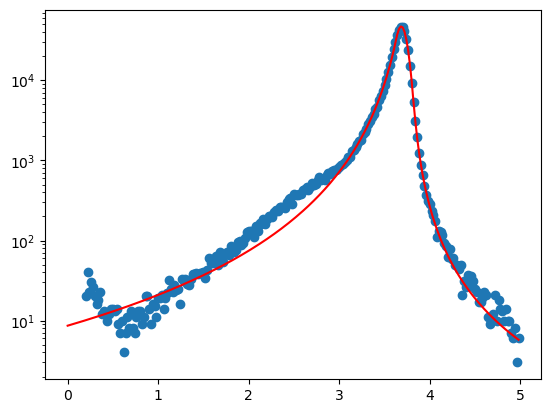

In [34]:
#fit avec crystall ball 2
#CrystalBall2(x, mu, sigma, alpha, alpha1, n, nbis, N)
alpha_fit_CB2_Psi = (3.2-mu_fit_gauss_Psi)/sigma_fit_gauss_Psi
alphabis_fit_CB2_Psi = (3.85-mu_fit_gauss_Psi)/sigma_fit_gauss_Psi
popt_CB2_Psi, pcov_CB2_Psi = curve_fit(CrystalBall2, x_data, y_data_Psi, p0=[mu_fit_gauss_Psi,sigma_fit_gauss_Psi,alpha_fit_CB2_Psi,alphabis_fit_CB2_Psi,1,1,N_fit_gauss_Psi])
print(popt_CB2_Psi)
x_moy_fit_CB2_Psi,sigma_fit_CB2_Psi,alpha_fit_CB2_Psi,alpha1_fit_CB2_Psi,n_fit_CB2_Psi,n1_fit_CB2_Psi,N_fit_CB2_Psi = popt_CB2_Psi
y_data_fit_Psi=CrystalBall2(x_data,x_moy_fit_CB2_Psi,sigma_fit_CB2_Psi,alpha_fit_CB2_Psi,alpha1_fit_CB2_Psi,n_fit_CB2_Psi,n1_fit_CB2_Psi,N_fit_CB2_Psi) #premier argument : variable indépendante x
print("Psi : mu = ", x_moy_fit_CB2_Psi, "\n sigma = ", sigma_fit_CB2_Psi, "\n alpha = ", alpha_fit_CB2_Psi, "\n alphabis = ", alpha1_fit_CB2_Psi,"\n n = ", n_fit_CB2_Psi, "\n nbis = ", n1_fit_CB2_Psi, "\n N = ", N_fit_CB2_Psi)

plt.scatter(x_data,y_data_Psi)
plt.semilogy(x_data,y_data_fit_Psi,'r')
#plt.yscale("log")
plt.show()

[3.08342410e+00 7.52305969e-02 1.76665003e+04]


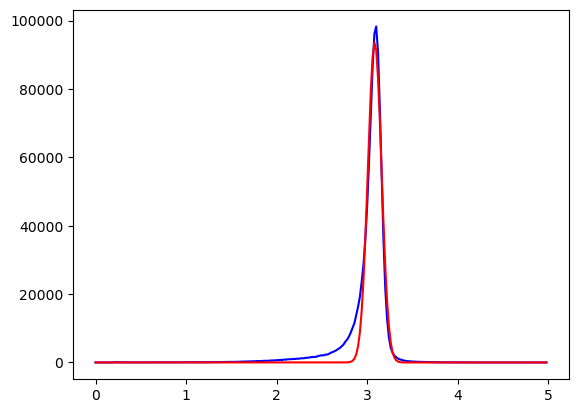

In [20]:
#fit avec gaussienne sur J-Psi
popt_gauss_Jpsi, pcov_gauss_Jpsi = curve_fit(gauss, x_data, y_data_Jpsi, p0=[3.,0.1,1])
print(popt_gauss_Jpsi)
mu_fit_gauss_Jpsi=popt_gauss_Jpsi[0]
sigma_fit_gauss_Jpsi=popt_gauss_Jpsi[1]
N_fit_gauss_Jpsi=popt_gauss_Jpsi[2]
y_data_fit_gauss_Jpsi=gauss(x_data,mu_fit_gauss_Jpsi,sigma_fit_gauss_Jpsi,N_fit_gauss_Jpsi)
plt.plot(x_data,y_data_Jpsi,'b')
plt.plot(x_data,y_data_fit_gauss_Jpsi,'r')
plt.show()

/tmp/ipykernel_22583/1288034614.py:48: RuntimeWarning: invalid value encountered in double_scalars
  y = np.append(y, A*((B- (i -mu)/(sigma))**(-n)))


[ 3.09106796e+00  6.33492648e-02 -8.20366729e-01  2.12887015e+00
  3.21806811e+00  2.36873252e+00  9.91849100e+04]
JPsi : mu =  3.0910679595177286 
 sigma =  0.06334926480351027 
 alpha =  -0.8203667286925543 
 alphabis =  2.1288701493061883 
 n =  3.218068107049111 
 nbis =  2.3687325196482107 
 N =  99184.90995095455


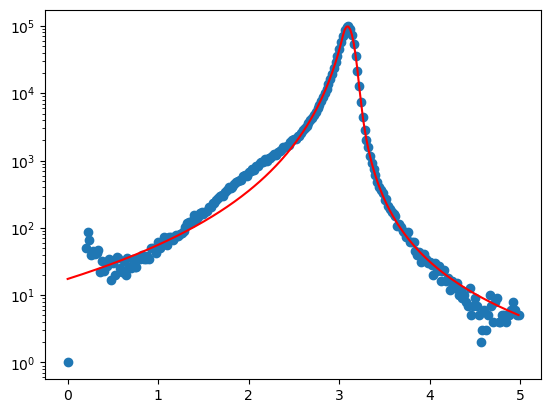

In [35]:
#fit avec crystall ball 2
#CrystalBall2(x, mu, sigma, alpha, alpha1, n, nbis, N)
alpha_fit_CB2_Jpsi = (2.6-mu_fit_gauss_Jpsi)/sigma_fit_gauss_Jpsi
alphabis_fit_CB2_Jpsi = (3.25-mu_fit_gauss_Jpsi)/sigma_fit_gauss_Jpsi
popt_CB2_Jpsi, pcov_CB2_Jpsi = curve_fit(CrystalBall2, x_data, y_data_Jpsi, p0=[mu_fit_gauss_Jpsi,sigma_fit_gauss_Jpsi,alpha_fit_CB2_Jpsi,alphabis_fit_CB2_Jpsi,1,1,N_fit_gauss_Jpsi])
print(popt_CB2_Jpsi)
x_moy_fit_CB2_Jpsi,sigma_fit_CB2_Jpsi,alpha_fit_CB2_Jpsi,alpha1_fit_CB2_Jpsi,n_fit_CB2_Jpsi,n1_fit_CB2_Jpsi,N_fit_CB2_Jpsi = popt_CB2_Jpsi
y_data_fit_Jpsi=CrystalBall2(x_data,x_moy_fit_CB2_Jpsi,sigma_fit_CB2_Jpsi,alpha_fit_CB2_Jpsi,alpha1_fit_CB2_Jpsi,n_fit_CB2_Jpsi,n1_fit_CB2_Jpsi,N_fit_CB2_Jpsi) #premier argument : variable indépendante x
print("JPsi : mu = ", x_moy_fit_CB2_Jpsi, "\n sigma = ", sigma_fit_CB2_Jpsi, "\n alpha = ", alpha_fit_CB2_Jpsi, "\n alphabis = ", alpha1_fit_CB2_Jpsi,"\n n = ", n_fit_CB2_Jpsi, "\n nbis = ", n1_fit_CB2_Jpsi, "\n N = ", N_fit_CB2_Jpsi)

plt.scatter(x_data,y_data_Jpsi)
plt.semilogy(x_data,y_data_fit_Jpsi,'r')
#plt.yscale("log")
plt.show()

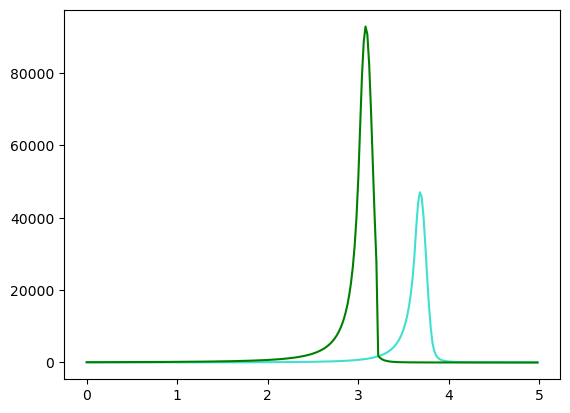

In [22]:
plt.plot(x_data,y_data_fit_Psi,color="turquoise")
plt.plot(x_data,y_data_fit_Jpsi,color="green")
#plt.yscale("log")
plt.show()

iinf :  51 isup :  141
[7.18998714e-07 4.91666679e-01 1.36376755e-07 1.57858391e+03]


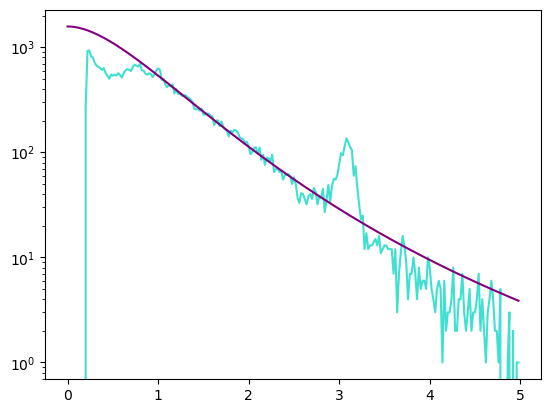

In [23]:
DATATYPE="data"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="." # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

def getTracks_2(events):
    return ak.zip({"px":events["Muon_Px"],
                       "py":events["Muon_Py"],
                       "pz":events["Muon_Pz"],
                       "E":events["Muon_E"],
                       "charge":events["Muon_Charge"],
                       "thetaAbs":events["Muon_thetaAbs"],
                       "matched":events["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

def scan_2(dataDescription, 
              hMag:hist.Hist, hPhi:hist.Hist, hInvMass:hist.Hist, hQualInvMass:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x),
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """

    for batch in uproot.iterate(dataDescription,
                                ["isCINT","isCMUL","isCMSL","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 step_size="100 MB", report=True):
        events=batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[0:5]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] #selection des évènements CMUL
        tracks = getTracks_2(events) #on utilise la fonction getTracks définie précédemment
        goodTracks=tracks[trackSelector(tracks)] #selection des évènements (eta, theta et trigger)
        
        #pairs = ak.combinations(goodTracks, 2)
        #one, two = ak.unzip(pairs)
        #rapidity_cut = (abs(one.eta<4)) & (abs(one.eta>2))
        #opposite_charge_cut = (one.charge + two.charge == 0) & (abs(one.eta<2))
        #quality_one = one[opposite_charge_cut]
        #quality_two = two[opposite_charge_cut]
        #invariant_mass = (quality_one + quality_two).mass
        
        pairs = ak.combinations(goodTracks, 2) #toutes les combinaisons de 2 traces
        one, two = ak.unzip(pairs)
        quality_one, quality_two = ak.unzip(pairs[(one.charge + two.charge == 0) & (abs(one.eta) <4) & (abs(one.eta)>2.5) 
                                                 & (abs(two.eta)<4) & (abs(two.eta)>2.5)]) #selection pairs signes opposées et y dans l'acceptance
        invariant_mass = (one + two).mass #masse invariante sans distinction des good pairs
        quality_invariant_mass = (quality_one + quality_two).mass #masse invariante avec correction
    
        hMag.fill(ak.flatten(goodTracks.p))
        hPhi.fill(ak.flatten(goodTracks.phi)) 
        hInvMass.fill(ak.flatten(invariant_mass))
        hQualInvMass.fill(ak.flatten(quality_invariant_mass))


        if verbose:
            print(batch[1])


def NoiseVWG(x, mu, alpha, beta, N):
    y = np.array([], dtype=float)
    for i in x:
        sigma = alpha + beta*((i-mu)/mu)
        y = np.append(y, N * np.exp(-((i-mu)**2)/(2*sigma**2)))
    return y

def NoisePR(x, a1, b1, b2, N):
    y = np.array([], dtype=float)
    for i in x:
        y = np.append(y, N*(1 + a1*i)/(b1*i + b2*i))
    return y
        
def NoiseDE(x, alpha, beta1, beta2, N):
    y = np.array([], dtype=float)
    for i in x:
        y = np.append(y, N*(np.exp(beta1*i) + alpha*np.exp(beta2*i)))
    return y
    
    
## SINGLE MUON TRACK PLOTS
#No cuts
vhMagRaw = hist.Hist(hist.axis.Regular(bins=250,start=0,stop=100,name='$|p|$'))
vhPhiRaw = hist.Hist(hist.axis.Regular(bins=250,start=-22/7,stop=22/7,name='$\phi$'))
vhInvMass = hist.Hist(hist.axis.Regular(bins=250,start=0,stop=5,name='invariant mass'))
vhQualInvMass = hist.Hist(hist.axis.Regular(bins=250,start=0,stop=5,name='invariant mass with good pairs'))
#Event selection
vhMagEvSel = hist.Hist(hist.axis.Regular(bins=250,start=0,stop=100,name='$|p|$'))
vhPhiEvSel = hist.Hist(hist.axis.Regular(bins=250,start=-22/7,stop=22/7,name='$\phi$'))
vhInvMassEvSel = hist.Hist(hist.axis.Regular(bins=250,start=0,stop=5,name='invariant mass'))
vhQualInvMassEvSel = hist.Hist(hist.axis.Regular(bins=250,start=0,stop=5,name='invariant mass with good pairs'))


scan_2(dataDescription=f"{BASEDIR}/run291694.{DATATYPE}.root:eventsTree",
          hMag=vhMagRaw, hPhi=vhPhiRaw, hInvMass=vhInvMass, hQualInvMass=vhQualInvMass)

scan_2(dataDescription=f"{BASEDIR}/run291694.{DATATYPE}.root:eventsTree",
          hMag=vhMagEvSel, hPhi=vhPhiEvSel, hInvMass=vhInvMassEvSel, hQualInvMass=vhQualInvMassEvSel,
          eventSelector=lambda x: x["isCMUL"]==True,
          trackSelector=lambda x: (x.eta<-2.5) & (x.eta>-4) & (x["thetaAbs"]>2) & (x["thetaAbs"]<9) & (x["matched"]==2))    
    
x_data=[]
y_data=[]
iinf = 0
isup = 0
      
for i in range(0,5000,20):
    x_data.append(i/1000)

for i in vhQualInvMassEvSel:
      y_data.append(i)
        
for i in range(0, 5000, 20):
    if (i/1000. > 1. ):
        iinf = int(i/20)
        break

for i in range(0, 5000, 20):
    if (i/1000. > 2.8):
        isup = int(i/20)
        break
        
print("iinf : ", iinf, "isup : ", isup)        

x_data_sorted = x_data[iinf:isup]
y_data_sorted = y_data[iinf:isup]

fit1, cov1 = curve_fit(NoiseVWG, x_data_sorted, y_data_sorted, maxfev=10000)
print(fit1)
y_fit_noise = NoiseVWG(x_data, float(fit1[0]), float(fit1[1]), float(fit1[2]), float(fit1[3]))

plt.semilogy(x_data, y_data, color="turquoise", label="data")
plt.semilogy(x_data, y_fit_noise, color="purple", label="Noise VWG")

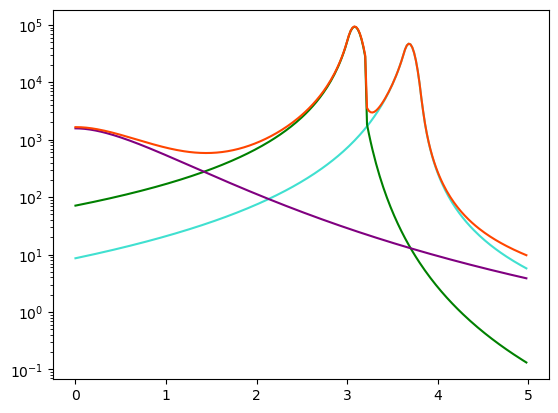

In [24]:
y_fit_tot = y_fit_noise + y_data_fit_Psi + y_data_fit_Jpsi

plt.semilogy(x_data,y_data_fit_Psi,color="turquoise")
plt.semilogy(x_data,y_data_fit_Jpsi,color="green")
plt.semilogy(x_data,y_fit_noise, color="purple")
plt.semilogy(x_data,y_fit_tot, color="orangered")
#plt.yscale("log")
plt.show()